In [33]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# Load & Normalize Data (-1 to 1)

In [34]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(X_train[:60000]).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [35]:
# FASHION MNIST

(X_train_fash, y_train_fash), (X_test_fash, y_test_fash) = tf.keras.datasets.fashion_mnist.load_data()
X_train_fash = X_train_fash.reshape(X_train_fash.shape[0], 28, 28, 1).astype('float32')
X_test_fash = X_test_fash.reshape(X_test_fash.shape[0], 28, 28, 1).astype('float32')

X_train_fash = (X_train_fash - 127.5) / 127.5
X_test_fash = (X_test_fash - 127.5) / 127.5

# Prepare Datasets

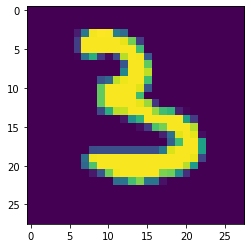

In [36]:
plt.imshow(X_train[y_train == 3][999])

In [37]:
classes = {}

for i in range(10):
    classes[f"df_{i}"] = X_train[:60000][y_train[:60000] == i]

In [38]:
# FASHION MNIST
fashion_classes = {}

for i in range(10):
    fashion_classes[f"df_{i}"] = X_train_fash[:60000][y_train_fash[:60000] == i]

for i in range(10):
    print(i, len(fashion_classes[f"df_{i}"]))

0 6000
1 6000
2 6000
3 6000
4 6000
5 6000
6 6000
7 6000
8 6000
9 6000


In [39]:
for i in range(10):
    print(i, len(classes[f"df_{i}"]))

0 5923
1 6742
2 5958
3 6131
4 5842
5 5421
6 5918
7 6265
8 5851
9 5949


In [40]:
train_dataset_0 = tf.data.Dataset.from_tensor_slices(classes["df_0"][:2000]).shuffle(len(classes["df_0"][:1000])).batch(BATCH_SIZE)
train_dataset_1 = tf.data.Dataset.from_tensor_slices(classes["df_1"][:2000]).shuffle(len(classes["df_1"][:2000])).batch(BATCH_SIZE)
train_dataset_2 = tf.data.Dataset.from_tensor_slices(classes["df_2"][:2000]).shuffle(len(classes["df_2"][:2000])).batch(BATCH_SIZE)
train_dataset_3 = tf.data.Dataset.from_tensor_slices(classes["df_3"][:2000]).shuffle(len(classes["df_3"][:2000])).batch(BATCH_SIZE)
train_dataset_4 = tf.data.Dataset.from_tensor_slices(classes["df_4"][:2000]).shuffle(len(classes["df_4"][:2000])).batch(BATCH_SIZE)
train_dataset_5 = tf.data.Dataset.from_tensor_slices(classes["df_5"][:2000]).shuffle(len(classes["df_5"][:2000])).batch(BATCH_SIZE)
train_dataset_6 = tf.data.Dataset.from_tensor_slices(classes["df_6"][:2000]).shuffle(len(classes["df_6"][:2000])).batch(BATCH_SIZE)
train_dataset_7 = tf.data.Dataset.from_tensor_slices(classes["df_7"][:2000]).shuffle(len(classes["df_7"][:2000])).batch(BATCH_SIZE)
train_dataset_8 = tf.data.Dataset.from_tensor_slices(classes["df_8"][:2000]).shuffle(len(classes["df_8"][:2000])).batch(BATCH_SIZE)
train_dataset_9 = tf.data.Dataset.from_tensor_slices(classes["df_9"][:2000]).shuffle(len(classes["df_9"][:2000])).batch(BATCH_SIZE)

In [41]:
train_dataset_0_fash = tf.data.Dataset.from_tensor_slices(fashion_classes["df_0"]).shuffle(len(fashion_classes["df_0"])).batch(BATCH_SIZE)
train_dataset_1_fash = tf.data.Dataset.from_tensor_slices(fashion_classes["df_1"]).shuffle(len(fashion_classes["df_1"])).batch(BATCH_SIZE)
train_dataset_2_fash = tf.data.Dataset.from_tensor_slices(fashion_classes["df_2"]).shuffle(len(fashion_classes["df_2"])).batch(BATCH_SIZE)
train_dataset_3_fash = tf.data.Dataset.from_tensor_slices(fashion_classes["df_3"]).shuffle(len(fashion_classes["df_3"])).batch(BATCH_SIZE)
train_dataset_4_fash = tf.data.Dataset.from_tensor_slices(fashion_classes["df_4"]).shuffle(len(fashion_classes["df_4"])).batch(BATCH_SIZE)
train_dataset_5_fash = tf.data.Dataset.from_tensor_slices(fashion_classes["df_5"]).shuffle(len(fashion_classes["df_5"])).batch(BATCH_SIZE)
train_dataset_6_fash = tf.data.Dataset.from_tensor_slices(fashion_classes["df_6"]).shuffle(len(fashion_classes["df_6"])).batch(BATCH_SIZE)
train_dataset_7_fash = tf.data.Dataset.from_tensor_slices(fashion_classes["df_7"]).shuffle(len(fashion_classes["df_7"])).batch(BATCH_SIZE)
train_dataset_8_fash = tf.data.Dataset.from_tensor_slices(fashion_classes["df_8"]).shuffle(len(fashion_classes["df_8"])).batch(BATCH_SIZE)
train_dataset_9_fash = tf.data.Dataset.from_tensor_slices(fashion_classes["df_9"]).shuffle(len(fashion_classes["df_9"])).batch(BATCH_SIZE)

# Create GENERATOR

In [42]:
from tensorflow.keras import layers


def create_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

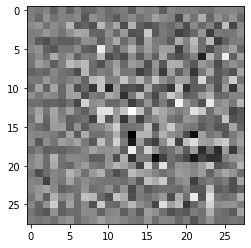

In [43]:
generator = create_generator_model()


noise = tf.random.normal([1,100])
img1 = generator(noise, training=False)

plt.imshow(img1[0, :, :, 0], cmap="gray")

# Create DISCRIMINATOR

In [44]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [45]:
discriminator = make_discriminator_model()

# Loss Functions

In [46]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [47]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#0.0001

# Checkpoints

In [48]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training Loop

In [49]:
noise_dim = 100


# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([BATCH_SIZE, noise_dim])


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
#@tf.function
def train_step(images, generator, discriminator, epoch):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss, d_real_loss, d_fake_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return disc_loss, d_real_loss, d_fake_loss, gen_loss, generated_images


In [153]:
import time

def train(dataset, dataclass,  epochs, generator, discriminator, save_images_dict):

  for epoch in range(epochs):
    start = time.time()

    # acc = 0
    for image_batch in dataset:
      disc_loss, d_real_loss, d_fake_loss, gen_loss, gen_images = train_step(image_batch, generator, discriminator, epoch)
      save_images_dict[epoch] = gen_images

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed,
                             dataclass)

    # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #  checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # print("Acc D:   ", acc/(len(dataset)))
    d_loss_plot.append(disc_loss/2)
    d_real_loss_plot.append(d_real_loss)
    d_fake_loss_plot.append(d_fake_loss)
    g_loss_plot.append(gen_loss)
    # acc_plot.append(disc_loss*0.5)

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed,
                           dataclass)
  # return gen_loss_dict, dis_loss_dict

# Create Images and save them

In [51]:
import os

def generate_and_save_images(model, epoch, test_input, dataclass):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  

  fig = plt.figure(figsize=(4, 4))
  for i in range(16):
    # pred = np.asarray(predictions[i, :, :, 0] * 127.5 + 127.5)
    #curr_IS = calculate_inception_score(pred)
    # gen.append(pred)
    
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  # Create directory to save generated images if not existent
  path = 'images/{}'.format(dataclass)
  if not os.path.exists(path):
    os.makedirs(path)
  plt.savefig('images/{}/image_epoch_{:04d}.png'.format(dataclass, epoch))
  plt.show()


# Explore MNIST Classes

In [212]:
(X_train_explore, y_train_explore), (_, _) = tf.keras.datasets.mnist.load_data()

X_train_explore = X_train_explore.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [213]:
X_train_explore[y_train_explore==0][0].shape

(28, 28, 1)

In [214]:
mean_pixels_dict = {}

for i in range(10):
    mean_pxl = np.zeros((784,1))
    for img in X_train_explore[y_train_explore==i]:
        for pixel in enumerate(img.reshape(784,1)):
            #print(pixel[1][0])
            mean_pxl[pixel[0]] += pixel[1][0]
    mean_pxl /= len(X_train_explore[y_train_explore==i])
    mean_pixels_dict[i] = mean_pxl

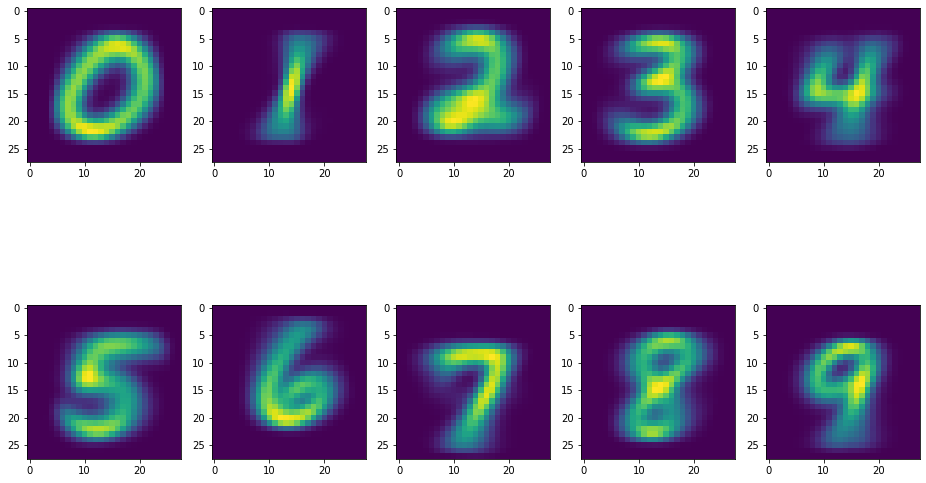

In [215]:
plt.figure(figsize=(16,10))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(mean_pixels_dict[i].reshape(28,28,1), cmap="viridis")
plt.show()

In [216]:
# Euclidean Distance
from scipy.spatial import distance

euclidean_distances = np.zeros((10,10))

for i in range(10):
    for j in range(10):
        euclidean_distances[i,j] = distance.euclidean(mean_pixels_dict[i], mean_pixels_dict[j])

In [217]:
for i, l in enumerate(euclidean_distances):
    mi = min(l[l>0])
    ma = max(l)
    print(f"MIN: {i}", mi, np.where(l == mi)[0][0])
    print(f"MAX: {i}", ma, np.where(l == ma)[0][0])
    print()


MIN: 0 1156.0263190402593 5
MAX: 0 1928.3782341495692 1

MIN: 1 1214.412115446305 8
MAX: 1 1928.3782341495692 0

MIN: 2 980.570899404891 8
MAX: 2 1434.3521498562832 0

MIN: 3 794.5804617337911 5
MAX: 3 1425.1059108147604 0

MIN: 4 633.6190287227882 9
MAX: 4 1592.144643092031 0

MIN: 5 791.404879205049 8
MAX: 5 1232.1156426912123 1

MIN: 6 1007.4013461244358 2
MAX: 6 1449.5604968921102 0

MIN: 7 761.597314960273 9
MAX: 7 1619.2318065717634 0

MIN: 8 791.404879205049 5
MAX: 8 1431.3619388004126 0

MIN: 9 633.6190287227882 4
MAX: 9 1575.248866165563 0



In [218]:
np.tril(euclidean_distances/100)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [19.28378234,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [14.3435215 , 12.915677  ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [14.25105911, 13.08738969, 11.20188054,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [15.92144643, 14.43459847, 12.07012994, 13.39820782,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [11.56026319, 12.32115643, 11.5411856 ,  7.94580462, 10.50447512,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [14.49560497, 14.48783446, 10.07401346, 13.69527866, 10.93183226,
        11.13775724,  0.        ,  0.        

<AxesSubplot:>

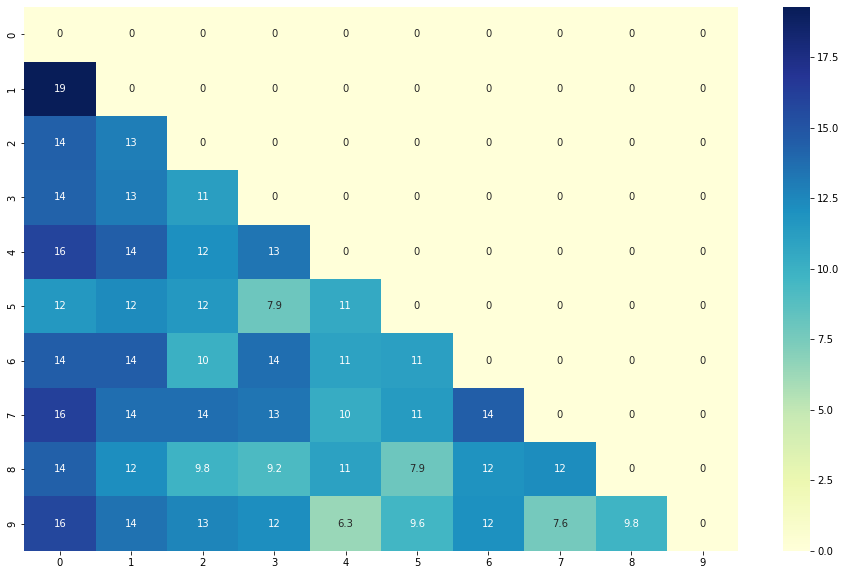

In [220]:
import seaborn as sns

plt.figure(figsize=(16,10))
sns.heatmap(np.tril(euclidean_distances/100), cmap="YlGnBu", annot=True)

In [ ]:
plt.figure(figsize=(16,10))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.hist(mean_pixels_dict[i])
    plt.title(i)
plt.show()

# PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
proj = pca.fit_transform(X_train_explore.reshape(-1,784))
plt.figure(figsize=(16,10))
plt.scatter(proj[:,0], proj[:,1], c=y_train_explore, cmap="Paired")
plt.colorbar(ticks=range(10))
plt.show

In [ ]:
# from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.manifold import TSNE

embeddings = TSNE(n_jobs=2).fit_transform(X_train_explore.reshape(-1,784))
figure = plt.figure(figsize=(16,10))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=y_train_explore, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5,9.5)

# Train GAN Models

In [249]:
def plot_loss(title, d_loss, g_loss, d_loss_real=None, d_loss_fake=None):
  plt.figure(figsize=(16,10))
  plt.plot(g_loss_plot, c="green")
  if (d_loss_real and d_loss_fake):
    plt.plot(d_loss, "--", c="orange")
    plt.plot(d_loss_real, c="blue")
    plt.plot(d_loss_fake, c="red")
    plt.fill_between(np.arange(len(d_loss)),d_loss_real, d_loss_fake, alpha=0.4)
    plt.legend(["Generator","Discriminator (Average)", "Discriminator (Real Images)","Discriminator (Fake Images)"], fontsize=14)

  else:
    plt.plot(d_loss)
    plt.legend(["Generator","Discriminator (Average)"], fontsize=14)

  if len(title) > 1:
    plt.title(f"{title[1]}: Discriminator and Generator Loss (Pre-trained on {title[0]})", fontsize=16)
  else:
    plt.title(f"{title}: Discriminator and Generator Loss", fontsize=16)
  plt.ylabel("Loss", fontsize=14)
  plt.xlabel("Epoch", fontsize=14)
  plt.tight_layout()
  plt.savefig(f"images/{title}/loss_plot_{title}.svg", dpi=600, format="svg")
  plt.show()

## GAN_0

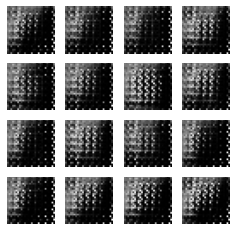

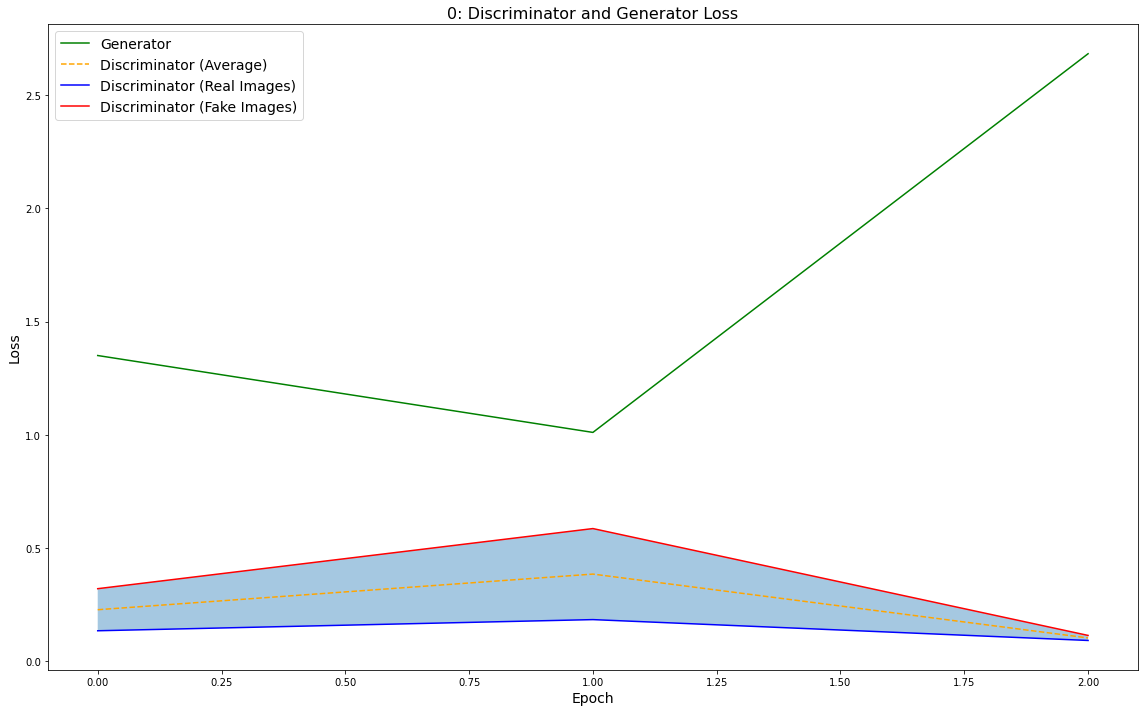

In [250]:
# Dict to save dicts with generated images per epoche
GAN_0 = {}

generator_0 = create_generator_model()
discriminator_0 = make_discriminator_model()

gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
d_real_loss_plot = []
d_fake_loss_plot = []
g_loss_plot = []

train(train_dataset_0, 0, 3, generator=generator_0, discriminator=discriminator_0, save_images_dict=GAN_0)

plot_loss("0", d_loss_plot, g_loss_plot, d_real_loss_plot, d_fake_loss_plot)

In [ ]:
generator_01 = tf.keras.models.clone_model(generator_0)
generator_01.build((None, 100)) # replace 10 with number of variables in input layer
generator_01.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
generator_01.set_weights(generator_0.get_weights())

discriminator_01 = tf.keras.models.clone_model(discriminator_0)
discriminator_01.build((None, [28, 28, 1])) # replace 10 with number of variables in input layer
discriminator_01.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
discriminator_01.set_weights(discriminator_0.get_weights())


gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
d_real_loss_plot = []
d_fake_loss_plot = []
g_loss_plot = []

GAN_01 = {}
train(train_dataset_1, 300, generator=generator_01, discriminator=discriminator_01, save_images_dict=GAN_01)

# Loss plots
plot_loss("01", d_loss_plot, g_loss_plot, d_real_loss_plot, d_fake_loss_plot)

In [ ]:
generator_02 = tf.keras.models.clone_model(generator_0)
generator_02.build((None, 100)) # replace 10 with number of variables in input layer
generator_02.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
generator_02.set_weights(generator_0.get_weights())

discriminator_02 = tf.keras.models.clone_model(discriminator_0)
discriminator_02.build((None, [28, 28, 1])) # replace 10 with number of variables in input layer
discriminator_02.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
discriminator_02.set_weights(discriminator_0.get_weights())


gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
d_real_loss_plot = []
d_fake_loss_plot = []
g_loss_plot = []

GAN_02 = {}
train(train_dataset_2, 50, generator=generator_02, discriminator=discriminator_02, save_images_dict=GAN_02)

# Loss plots
plt.figure(figsize=(16,10))
plt.plot(d_loss_plot)
#plt.plot(d_real_loss_plot)
#plt.plot(d_fake_loss_plot)
plt.plot(g_loss_plot)
plt.title("Discriminator and Generator Loss")
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.legend(["Discriminator", "Generator"], fontsize=12)
plt.show()

In [ ]:
generator_03 = tf.keras.models.clone_model(generator_0)
generator_03.build((None, 100)) # replace 10 with number of variables in input layer
generator_03.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
generator_03.set_weights(generator_0.get_weights())

discriminator_03 = tf.keras.models.clone_model(discriminator_0)
discriminator_03.build((None, [28, 28, 1])) # replace 10 with number of variables in input layer
discriminator_03.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
discriminator_03.set_weights(discriminator_0.get_weights())


gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
d_real_loss_plot = []
d_fake_loss_plot = []
g_loss_plot = []

GAN_03 = {}
train(train_dataset_3, 50, generator=generator_03, discriminator=discriminator_03, save_images_dict=GAN_03)


# Loss plots
plt.figure(figsize=(16,10))
# plt.plot(d_loss_plot)
plt.plot(d_real_loss_plot)
plt.plot(d_fake_loss_plot)
plt.plot(g_loss_plot)
plt.title("Discriminator and Generator Loss")
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.legend(["Discriminator Real", "Discriminator Fake", "Generator"], fontsize=12)
plt.show()

In [ ]:
generator_04 = tf.keras.models.clone_model(generator_0)
generator_04.build((None, 100)) # replace 10 with number of variables in input layer
generator_04.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
generator_04.set_weights(generator_0.get_weights())

discriminator_04 = tf.keras.models.clone_model(discriminator_0)
discriminator_04.build((None, [28, 28, 1])) # replace 10 with number of variables in input layer
discriminator_04.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
discriminator_04.set_weights(discriminator_0.get_weights())


gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
d_real_loss_plot = []
d_fake_loss_plot = []
g_loss_plot = []

GAN_04 = {}
train(train_dataset_4, 50, generator=generator_04, discriminator=discriminator_04, save_images_dict=GAN_04)


# Loss plots
plt.figure(figsize=(16,10))
# plt.plot(d_loss_plot)
plt.plot(d_real_loss_plot)
plt.plot(d_fake_loss_plot)
plt.plot(g_loss_plot)
plt.title("Discriminator and Generator Loss")
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.legend(["Discriminator Real", "Discriminator Fake", "Generator"], fontsize=12)
plt.show()

In [ ]:
generator_05 = tf.keras.models.clone_model(generator_0)
generator_05.build((None, 100)) # replace 10 with number of variables in input layer
generator_05.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
generator_05.set_weights(generator_0.get_weights())

discriminator_05 = tf.keras.models.clone_model(discriminator_0)
discriminator_05.build((None, [28, 28, 1])) # replace 10 with number of variables in input layer
discriminator_05.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
discriminator_05.set_weights(discriminator_0.get_weights())


gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
g_loss_plot = []

GAN_05 = {}
train(train_dataset_5, 50, generator=generator_05, discriminator=discriminator_05, save_images_dict=GAN_05)


# Loss plots
plt.figure(figsize=(16,10))
# plt.plot(d_loss_plot)
plt.plot(d_real_loss_plot)
plt.plot(d_fake_loss_plot)
plt.plot(g_loss_plot)
plt.title("Discriminator and Generator Loss")
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.legend(["Discriminator Real", "Discriminator Fake", "Generator"], fontsize=12)
plt.show()

In [ ]:
generator_06 = tf.keras.models.clone_model(generator_0)
generator_06.build((None, 100)) # replace 10 with number of variables in input layer
generator_06.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
generator_06.set_weights(generator_0.get_weights())

discriminator_06 = tf.keras.models.clone_model(discriminator_0)
discriminator_06.build((None, [28, 28, 1])) # replace 10 with number of variables in input layer
discriminator_06.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
discriminator_06.set_weights(discriminator_0.get_weights())


gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
g_loss_plot = []

GAN_06 = {}
train(train_dataset_6, 100, generator=generator_06, discriminator=discriminator_06, save_images_dict=GAN_06)


# Loss plots
plt.figure(figsize=(16,10))
# plt.plot(d_loss_plot)
plt.plot(d_real_loss_plot)
plt.plot(d_fake_loss_plot)
plt.plot(g_loss_plot)
plt.title("Discriminator and Generator Loss")
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.legend(["Discriminator Real", "Discriminator Fake", "Generator"], fontsize=12)
plt.show()

# GAN 1

# GAN 2

# GAN 3

In [ ]:
# Dict to save dicts with generated images per epoche
GAN_3 = {}

generator_3 = create_generator_model()
discriminator_3 = make_discriminator_model()

gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
d_real_loss_plot = []
d_fake_loss_plot = []
g_loss_plot = []

train(train_dataset_3, 3, 200, generator=generator_3, discriminator=discriminator_3, save_images_dict=GAN_3)

# Loss plots
plt.figure(figsize=(16,10))
plt.plot(d_loss_plot)
#plt.plot(d_real_loss_plot)
#plt.plot(d_fake_loss_plot)
plt.plot(g_loss_plot)
plt.title("Discriminator and Generator Loss")
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.legend(["Discriminator Loss", "Generator"], fontsize=12)
plt.show()

In [ ]:
generator_38 = tf.keras.models.clone_model(generator_3)
generator_38.build((None, 100)) # replace 10 with number of variables in input layer
generator_38.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
generator_38.set_weights(generator_3.get_weights())

discriminator_38 = tf.keras.models.clone_model(discriminator_3)
discriminator_38.build((None, [28, 28, 1])) # replace 10 with number of variables in input layer
discriminator_38.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
discriminator_38.set_weights(discriminator_3.get_weights())


gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
d_real_loss_plot = []
d_fake_loss_plot = []
g_loss_plot = []

GAN_38 = {}
train(train_dataset_8, 38, 200, generator=generator_38, discriminator=discriminator_38, save_images_dict=GAN_38)


# Loss plots
plt.figure(figsize=(16,10))
plt.plot(d_loss_plot)
#plt.plot(d_real_loss_plot)
#plt.plot(d_fake_loss_plot)
plt.plot(g_loss_plot)
plt.title("Discriminator and Generator Loss")
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.legend(["Discriminator Loss", "Generator"], fontsize=12)
plt.show()

# GAN 4

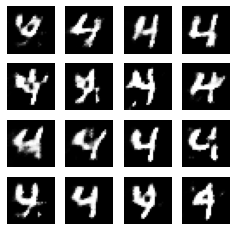

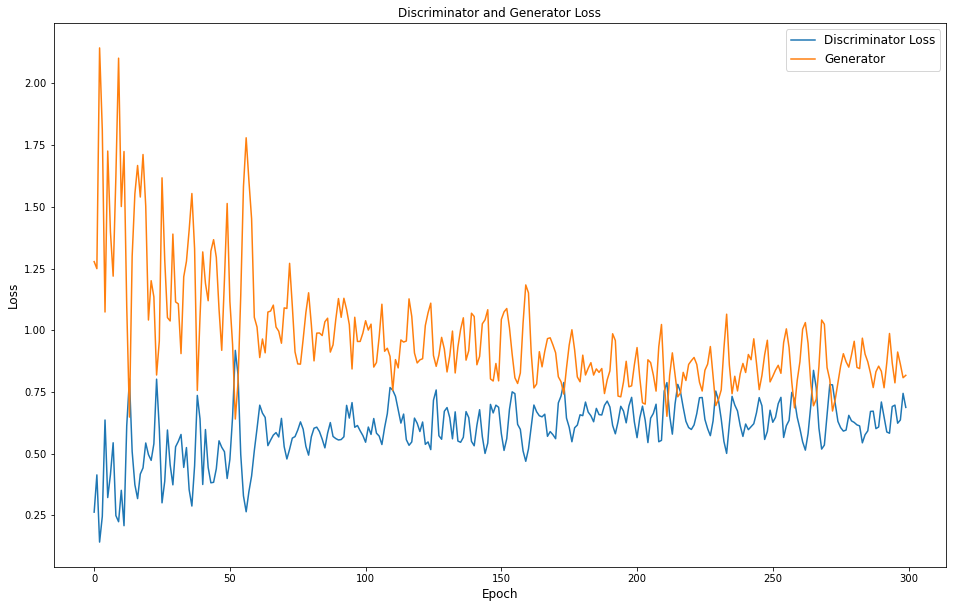

In [230]:
# Dict to save dicts with generated images per epoche
GAN_4 = {}

generator_4 = create_generator_model()
discriminator_4 = make_discriminator_model()

gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
d_real_loss_plot = []
d_fake_loss_plot = []
g_loss_plot = []

train(train_dataset_4, 4, 300, generator=generator_4, discriminator=discriminator_4, save_images_dict=GAN_4)

# Loss plots
plt.figure(figsize=(16,10))
plt.plot(d_loss_plot)
#plt.plot(d_real_loss_plot)
#plt.plot(d_fake_loss_plot)
plt.plot(g_loss_plot)
plt.title("Discriminator and Generator Loss")
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.legend(["Discriminator Loss", "Generator"], fontsize=12)
plt.show()

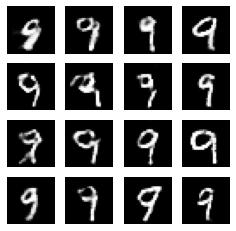

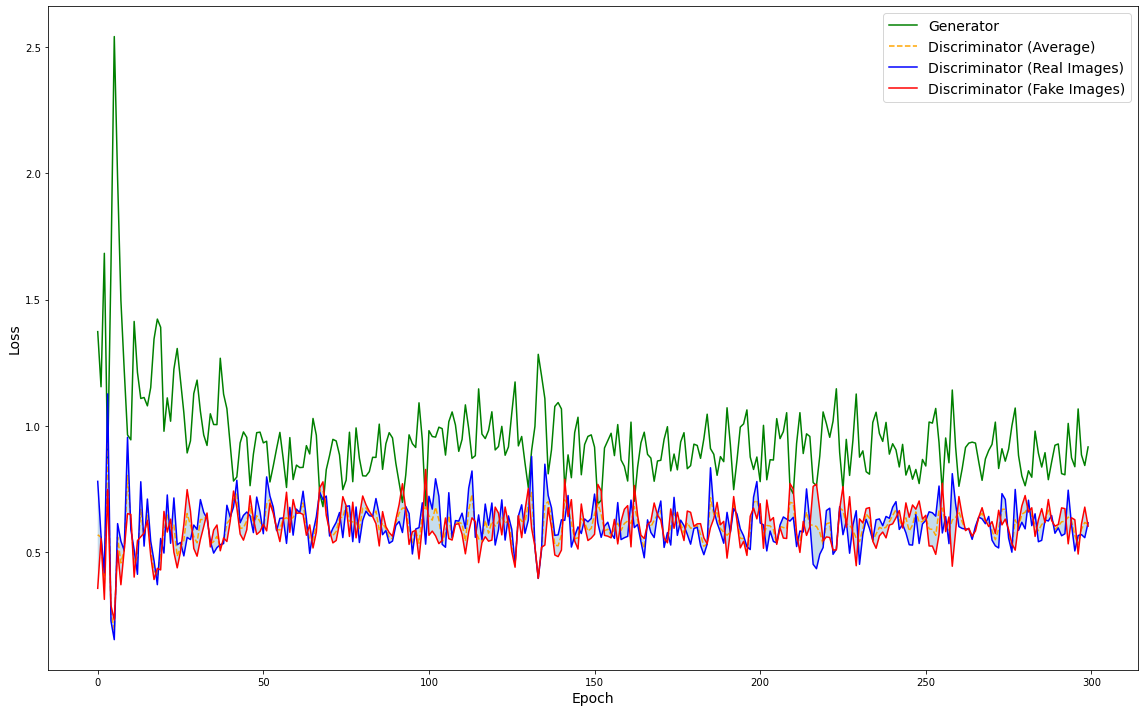

In [234]:
generator_49 = tf.keras.models.clone_model(generator_4)
generator_49.build((None, 100)) # replace 10 with number of variables in input layer
generator_49.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
generator_49.set_weights(generator_4.get_weights())

discriminator_49 = tf.keras.models.clone_model(discriminator_4)
discriminator_49.build((None, [28, 28, 1])) # replace 10 with number of variables in input layer
discriminator_49.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
discriminator_49.set_weights(discriminator_4.get_weights())


gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
d_real_loss_plot = []
d_fake_loss_plot = []
g_loss_plot = []

GAN_49 = {}
train(train_dataset_9, 49, 300, generator=generator_49, discriminator=discriminator_49, save_images_dict=GAN_49)

# Loss plots
plot_loss("49", d_loss_plot, g_loss_plot, d_real_loss_plot, d_fake_loss_plot)

In [ ]:
import time

time.sleep(60)

# GAN 5

# GAN 6

# GAN 7

# GAN 8

In [ ]:
# Dict to save dicts with generated images per epoche
GAN_8 = {}

generator_8 = create_generator_model()
discriminator_8 = make_discriminator_model()

gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
d_real_loss_plot = []
d_fake_loss_plot = []
g_loss_plot = []

train(train_dataset_8, 200, generator=generator_8, discriminator=discriminator_8, save_images_dict=GAN_8)

# Loss plots
plt.figure(figsize=(16,10))
plt.plot(d_loss_plot)
#plt.plot(d_real_loss_plot)
#plt.plot(d_fake_loss_plot)
plt.plot(g_loss_plot)
plt.title("Discriminator and Generator Loss")
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.legend(["Discriminator Loss", "Generator"], fontsize=12)
plt.show()

# GAN 9

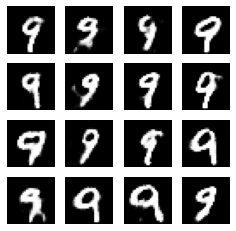

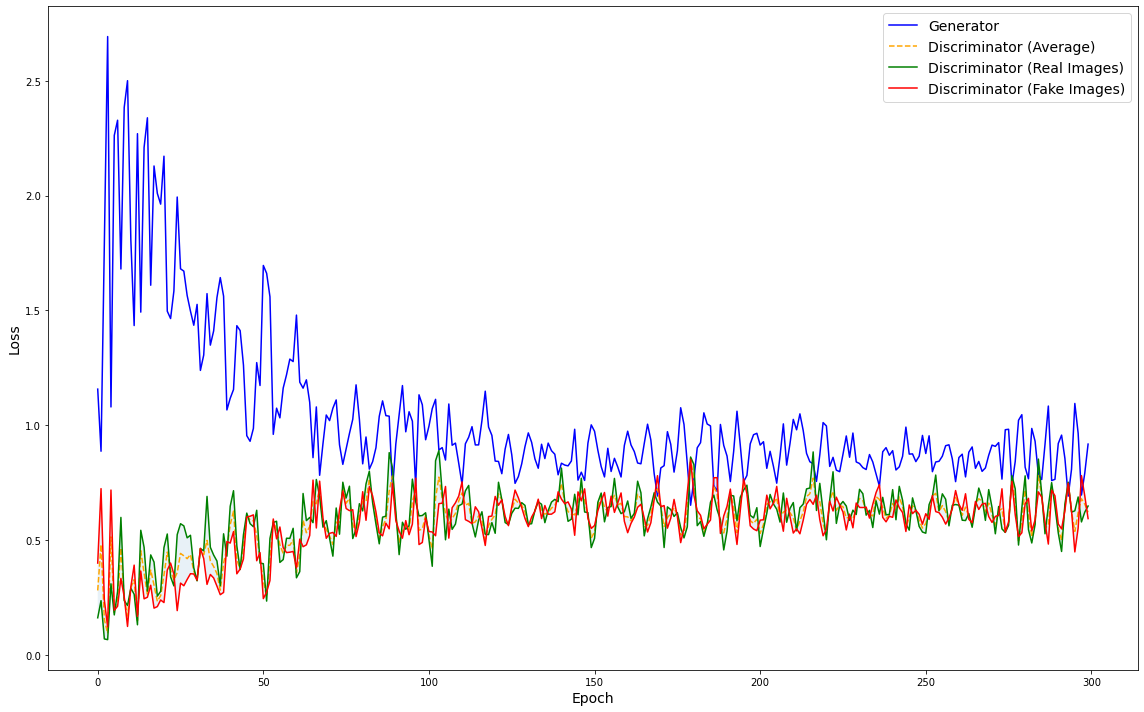

In [202]:
# Dict to save dicts with generated images per epoche
GAN_9 = {}

generator_9 = create_generator_model()
discriminator_9 = make_discriminator_model()

gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
d_real_loss_plot = []
d_fake_loss_plot = []
g_loss_plot = []

train(train_dataset_9, 9, 300, generator=generator_9, discriminator=discriminator_9, save_images_dict=GAN_9)

# Loss plots
plot_loss("9", d_loss_plot, g_loss_plot, d_real_loss_plot, d_fake_loss_plot)

In [ ]:
time.sleep(60)

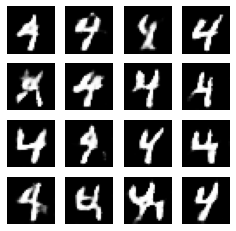

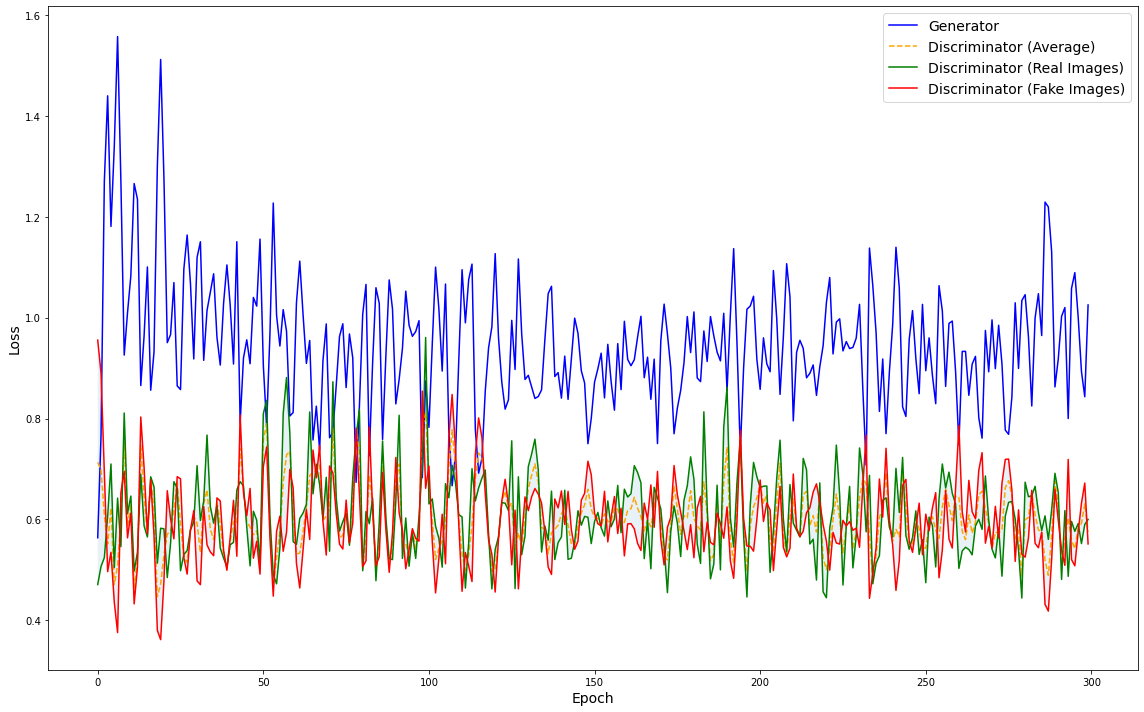

In [203]:
generator_94 = tf.keras.models.clone_model(generator_9)
generator_94.build((None, 100)) # replace 10 with number of variables in input layer
generator_94.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
generator_94.set_weights(generator_9.get_weights())

discriminator_94 = tf.keras.models.clone_model(discriminator_9)
discriminator_94.build((None, [28, 28, 1])) # replace 10 with number of variables in input layer
discriminator_94.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
discriminator_94.set_weights(discriminator_9.get_weights())


gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
d_real_loss_plot = []
d_fake_loss_plot = []
g_loss_plot = []

GAN_94 = {}
train(train_dataset_4, 94, 300, generator=generator_94, discriminator=discriminator_94, save_images_dict=GAN_94)


# Loss plots
plot_loss("94", d_loss_plot, g_loss_plot, d_real_loss_plot, d_fake_loss_plot)

# SVM

In [205]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score




In [206]:
unique, counts = np.unique(y_train[:20000], return_counts=True)
unique_t, counts_t = np.unique(y_test, return_counts=True)

In [207]:
for i in range(10):
    print(unique[i], counts[i])

0 1994
1 2281
2 1929
3 2076
4 1945
5 1775
6 1971
7 2093
8 1922
9 2014


In [208]:
# Prepare exact same data used for training to train the svm classifier
train_data_svm_x = []
train_data_svm_y = []
for i in range(10):
  for img in classes[f"df_{i}"][:2000]:
    train_data_svm_x.append(img)
    train_data_svm_y.append(i)

In [ ]:
svm_model = svm.SVC(kernel="rbf", C=5, gamma=0.01)
svm_model.fit(np.reshape(train_data_svm_x, (20000,784)), train_data_svm_y)

In [209]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

folds = KFold(n_splits = 5, shuffle = True, random_state = 10)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [5,10]}]


# specify model
model = svm.SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(np.reshape(train_data_svm_x,(20000,784)), train_data_svm_y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [5, 10], 'gamma': [0.01, 0.001, 0.0001]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [210]:
model_cv.best_params_

{'C': 5, 'gamma': 0.01}

In [211]:
predictions = model_cv.predict(X_test[:2000].reshape(2000, 784))
print(classification_report(y_test[:2000], predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       175
           1       0.99      0.99      0.99       234
           2       0.97      0.98      0.97       219
           3       0.97      0.97      0.97       207
           4       0.97      0.97      0.97       217
           5       0.97      0.97      0.97       179
           6       0.97      0.97      0.97       178
           7       0.96      0.93      0.95       205
           8       0.96      0.97      0.97       192
           9       0.95      0.94      0.95       194

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



In [235]:
# Transform images from dict to np.arrays 

"""
G_0_arr = np.empty(shape=(50, 80, 28, 28, 1))
for i in range(50):
    G_0_arr[i] = np.asarray(GAN_0[i])

G_01_arr = np.empty(shape=(50, 80, 28, 28, 1))
for i in range(50):
    G_01_arr[i] = np.asarray(GAN_01[i])

G_02_arr = np.empty(shape=(50, 80, 28, 28, 1))
for i in range(50):
    G_02_arr[i] = np.asarray(GAN_02[i])

G_03_arr = np.empty(shape=(50, 200, 28, 28, 1))
for i in range(50):
    G_03_arr[i] = np.asarray(GAN_03[i])

G_04_arr = np.empty(shape=(50, 200, 28, 28, 1))
for i in range(50):
    G_04_arr[i] = np.asarray(GAN_04[i])

G_05_arr = np.empty(shape=(50, 200, 28, 28, 1))
for i in range(50):
    G_05_arr[i] = np.asarray(GAN_05[i])

G_07_arr = np.empty(shape=(50, 32, 28, 28, 1))
for i in range(50):
    G_07_arr[i] = np.asarray(GAN_07[i])

G_3_arr = np.empty(shape=(200, 100, 28, 28, 1))
for i in range(200):
    G_3_arr[i] = np.asarray(GAN_3[i])

G_38_arr = np.empty(shape=(200, 100, 28, 28, 1))
for i in range(200):
    G_38_arr[i] = np.asarray(GAN_38[i])
"""

G_49_arr = np.empty(shape=(300, 128, 28, 28, 1))
for i in range(300):
    G_4_arr[i] = np.asarray(GAN_4[i])

G_49_arr = np.empty(shape=(300, 128, 28, 28, 1))
for i in range(300):
    G_49_arr[i] = np.asarray(GAN_49[i])

"""
G_8_arr = np.empty(shape=(200, 100, 28, 28, 1))
for i in range(200):
    G_8_arr[i] = np.asarray(GAN_8[i])
"""

G_9_arr = np.empty(shape=(300, 128, 28, 28, 1))
for i in range(300):
    G_9_arr[i] = np.asarray(GAN_9[i])

G_94_arr = np.empty(shape=(300, 128, 28, 28, 1))
for i in range(300):
    G_94_arr[i] = np.asarray(GAN_94[i])

In [224]:
# Function to save accuracies per epoch to csv file

def save_accuracy(accuracies_list, dataclass):
  # Create directory to save accuracies if not existent
  path = 'images/{}'.format(dataclass)
  if not os.path.exists(path):
    os.makedirs(path)
  df = pd.DataFrame(accuracies_list)
  df.to_csv(path + f"/{dataclass}.csv")

In [ ]:
from sklearn.metrics import accuracy_score

preds = []
plt.figure(figsize=(16,10))
for i in range(200):
    predictions = model_cv.predict(G_0_arr[i].reshape(100,784))
    # classification_report(np.full(shape=256, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=100, fill_value=0), predictions)
    preds.append(acc)
# Save accuracies to dataframe and save it locally
save_accuracy(preds, 0)
plt.plot(preds)
plt.show()

In [ ]:
preds = []
plt.figure(figsize=(16,10))
for i in range(50):
    predictions = model_cv.predict(G_01_arr[i].reshape(80,784))
    # classification_report(np.full(shape=256, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=80, fill_value=1), predictions)
    preds.append(acc)
plt.plot(preds)
plt.show()

In [ ]:
preds = []
plt.figure(figsize=(16,10))
for i in range(50):
    predictions = model_cv.predict(G_02_arr[i].reshape(80,784))
    # classification_report(np.full(shape=200, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=80, fill_value=2), predictions)
    preds.append(acc) 
plt.plot(preds)
plt.show()

In [ ]:
preds = []
plt.figure(figsize=(16,10))
for i in range(50):
    predictions = svm_model.predict(G_03_arr[i].reshape(200,784))
    # classification_report(np.full(shape=256, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=200, fill_value=3), predictions)
    preds.append(acc)
plt.plot(preds)
plt.show()

In [ ]:
preds = []
plt.figure(figsize=(16,10))
for i in range(50):
    predictions = svm_model.predict(G_04_arr[i].reshape(200,784))
    # classification_report(np.full(shape=256, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=200, fill_value=4), predictions)
    preds.append(acc)
plt.plot(preds)
plt.show()

In [ ]:
preds = []
plt.figure(figsize=(16,10))
for i in range(50):
    predictions = svm_model.predict(G_05_arr[i].reshape(200,784))
    # classification_report(np.full(shape=256, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=200, fill_value=5), predictions)
    preds.append(acc)
plt.plot(preds)
plt.show()

In [ ]:
preds = []
plt.figure(figsize=(16,10))
for i in range(200):
    predictions = svm_model.predict(G_3_arr[i].reshape(100,784))
    # classification_report(np.full(shape=256, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=100, fill_value=3), predictions)
    preds.append(acc)
plt.plot(preds)
plt.show()

In [ ]:
preds = []
plt.figure(figsize=(16,10))
for i in range(200):
    predictions = svm_model.predict(G_38_arr[i].reshape(100,784))
    # classification_report(np.full(shape=256, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=100, fill_value=8), predictions)
    preds.append(acc)
plt.plot(preds)
plt.show()

# SVM: 4

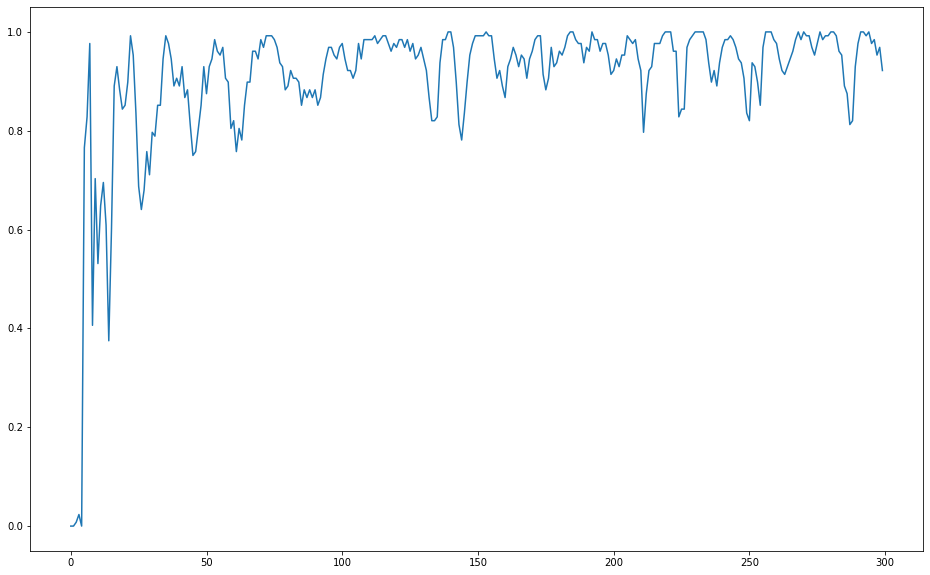

In [233]:
preds = []
plt.figure(figsize=(16,10))
for i in range(300):
    predictions = model_cv.predict(G_4_arr[i].reshape(128,784))
    # classification_report(np.full(shape=256, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=128, fill_value=4), predictions)
    preds.append(acc)
# Save accuracies to dataframe and save it locally
save_accuracy(preds, 4)
plt.plot(preds)
plt.show()

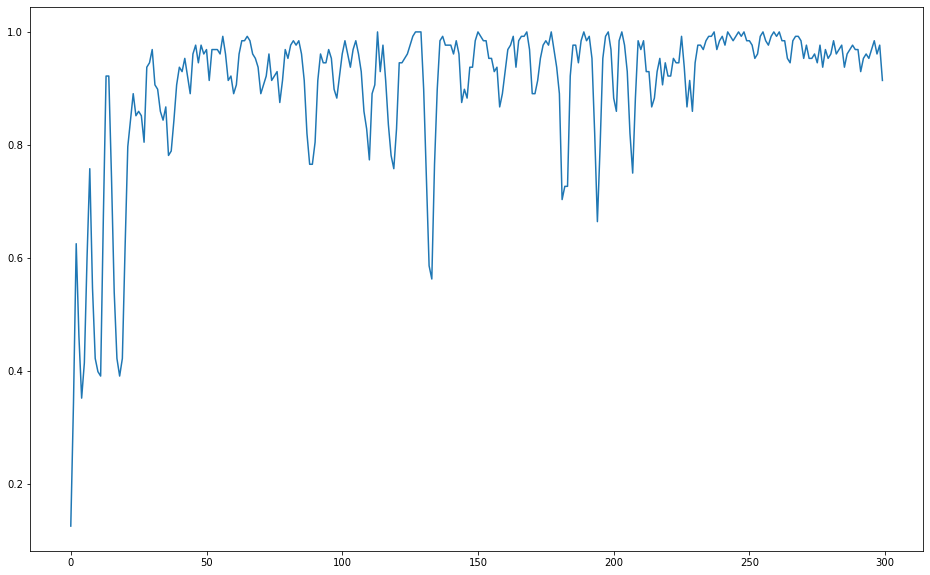

In [236]:
preds = []
plt.figure(figsize=(16,10))
for i in range(300):
    predictions = model_cv.predict(G_49_arr[i].reshape(128,784))
    # classification_report(np.full(shape=256, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=128, fill_value=9), predictions)
    preds.append(acc)
# Save accuracies to dataframe and save it locally
save_accuracy(preds, 49)
plt.plot(preds)
plt.show()

In [ ]:
preds = []
plt.figure(figsize=(16,10))
for i in range(200):
    predictions = svm_model.predict(G_8_arr[i].reshape(100,784))
    # classification_report(np.full(shape=256, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=100, fill_value=8), predictions)
    preds.append(acc)
plt.plot(preds)
plt.show()

# SVM: 9

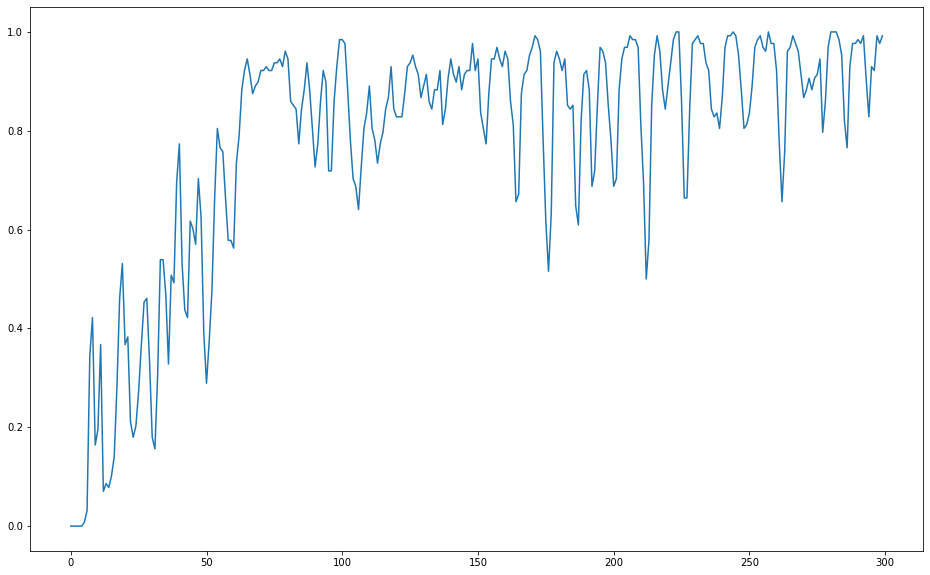

In [226]:
preds = []
plt.figure(figsize=(16,10))
for i in range(300):
    predictions = model_cv.predict(G_9_arr[i].reshape(128,784))
    # classification_report(np.full(shape=200, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=128, fill_value=9), predictions)
    preds.append(acc) 
# Save accuracies to dataframe and save it locally
save_accuracy(preds, 9)
plt.plot(preds)
plt.show()

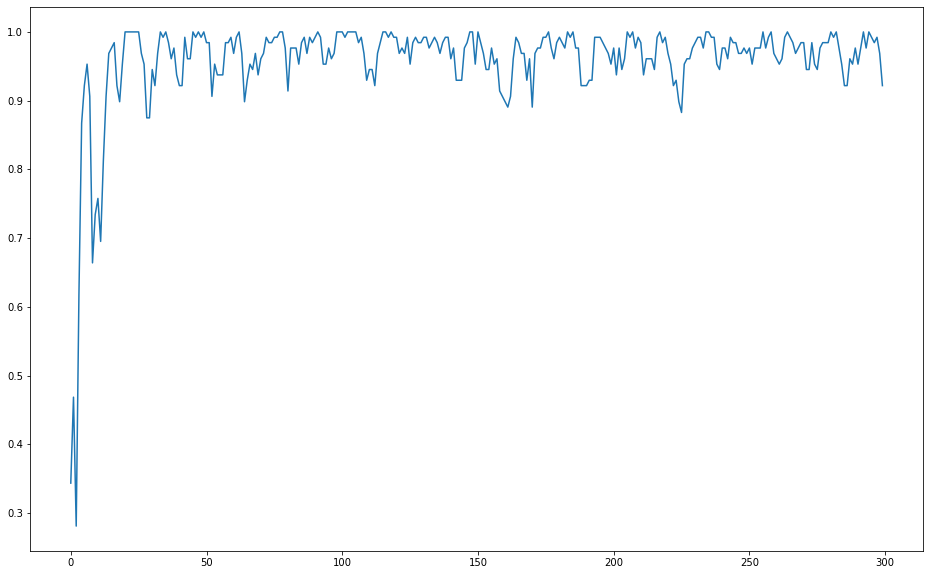

In [228]:
preds = []
plt.figure(figsize=(16,10))
for i in range(300):
    predictions = model_cv.predict(G_94_arr[i].reshape(128,784))
    # classification_report(np.full(shape=200, fill_value=2), predictions)
    acc = accuracy_score(np.full(shape=128, fill_value=4), predictions)
    preds.append(acc)
# Save accuracies to dataframe and save it locally
save_accuracy(preds, 94)
plt.plot(preds)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
 
grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2)
 
# fitting the model for grid search
grid.fit(X_train[:10000].reshape(10000, 784), y_train[:10000])

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

In [ ]:
X_t = X_test[:1677]
grid_predictions = grid.predict(X_t.reshape(1677,784))
print(classification_report(y_test[:1677], grid_predictions))

In [ ]:
svm2 = svm.SVC(gamma=0.1)
svm2.fit(X_train[:10000].reshape(10000,784), y_train[:10000])
predictions2 = svm2.predict(X_test[:1667].reshape(1667, 784))
print(classification_report(y_test[:1667], predictions2))

# cGAN (https://www.kaggle.com/jjjokkker/cgan-for-mnist)

In [ ]:
from __future__ import division, print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import itertools
import time
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2
from PIL import Image
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, AveragePooling2D, MaxPooling2D, UpSampling2D, Input, Reshape, Lambda, merge, Concatenate, Subtract, Reshape, multiply
from keras.layers import Embedding, ZeroPadding2D
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from tensorflow.keras.optimizers import Nadam, Adam, SGD
from tensorflow.keras.metrics import categorical_accuracy, binary_accuracy
from tensorflow.keras.callbacks import Callback, History
import tensorflow as tf
import pandas as pd
import glob
import PIL
from sys import getsizeof
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.ticker import MaxNLocator
from sklearn.utils import class_weight
from keras.datasets import mnist

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Image shape information
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
if len(X_train.shape) == 4:
    channels = X_train.shape[3]
else:
    channels = 1
img_shape = (img_rows, img_cols, channels)
num_classes = 10
latent_dim = 100
optimizer = Adam(0.0002, 0.5)

In [ ]:
def generator():
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    model.summary()
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))
    model_input = multiply([noise, label_embedding])
    img = model(model_input)
    return Model([noise, label], img)

In [ ]:
def discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=np.prod(img_shape)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    flat_img = Flatten()(img)
    model_input = multiply([flat_img, label_embedding])
    validity = model(model_input)
    return Model([img, label], validity)

In [ ]:
discriminator = discriminator()
discriminator.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=['accuracy'])
# Build the generator
generator = generator()
# The generator takes noise and the target label as input
# and generates the corresponding digit of that label
noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
img = generator([noise, label])
# For the combined model we will only train the generator
discriminator.trainable = False
# The discriminator takes generated image as input and determines validity
# and the label of that image
valid = discriminator([img, label])
# The combined model  (stacked generator and discriminator)
# Trains generator to fool discriminator
combined = Model([noise, label], valid)
combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)

In [ ]:
def sample_images(epoch, train_on=None):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    if train_on:
        sampled_labels = np.full(10, train_on).reshape(-1, 1)
    else:
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

    gen_imgs = generator.predict([noise, sampled_labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

In [ ]:
epochs=5000
batch_size=32
sample_interval=500

In [ ]:
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
y_train = y_train.reshape(-1, 1)

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))    

# Declaring empty lists to save the losses for plotting
d_loss_plot = []
g_loss_plot = []
acc_plot = []

In [ ]:
X_3 = []
X_8 = []
for i in range(len(X_train)):
    if y_train[i] == 3:
        X_3.append(i)
    if y_train[i] == 8:
        X_8.append(i)

In [ ]:
imgs, labels = X_train[X_3][idx], y_train[X_3][idx]
labels.shape

In [ ]:
for epoch in range(epochs):
    #Training the Discriminator
    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]
    # Sample noise as generator input
    noise = np.random.normal(0, 1, (batch_size, 100))
    # Generate a half batch of new images
    gen_imgs = generator.predict([noise, labels])
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    #Training the Generator
    # Condition on labels
    sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
    # Train the generator
    g_loss = combined.train_on_batch([noise, sampled_labels], valid)
    # Saving the Discriminator and Generator losses and accuracy for plotting
    d_loss_plot.append(d_loss[0])
    g_loss_plot.append(g_loss)
    acc_plot.append(d_loss[1])
    
    # Plot the progress every 100 epochs
    if epoch % 500 == 0:
        print ("%d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, epochs, d_loss[0], 100*d_loss[1], g_loss))
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 10).reshape(-1, 1)
        
        x_fake = generator.predict([z, labels])
        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()
        plt.show()
    # Saving generated image samples at every sample interval
    if epoch % sample_interval == 0:
        sample_images(epoch)

def train(gen, disc, epochs, X_train, y_train, train_on=None):
    if train_on:
        print(f"** TRAINING ON IMAGES WITH LABEL  {train_on} **")

    for epoch in range(epochs):
        #Training the Discriminator

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        # Sample noise as generator input
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Generate a half batch of new images
        gen_imgs = gen.predict([noise, labels])

        # Train the discriminator
        d_loss_real = disc.train_on_batch([imgs, labels], valid)
        d_loss_fake = disc.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        #Training the Generator

        # Condition on label
        sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        # Train the generator
        g_loss = combined.train_on_batch([noise, sampled_labels], valid)


        # Saving the Discriminator and Generator losses and accuracy for plotting
        d_loss_plot.append(d_loss[0])
        g_loss_plot.append(g_loss)
        acc_plot.append(d_loss[1])

        # Plot the progress every 500 epochs
        if epoch % 500 == 0:
            print ("%d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, epochs, d_loss[0], 100*d_loss[1], g_loss))

            samples = 10
            z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
            labels = np.arange(0, 10).reshape(-1, 1)
            
            x_fake = gen.predict([z, labels])

            for k in range(samples):
                plt.subplot(2, 5, k+1)
                plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
                plt.xticks([])
                plt.yticks([])

            plt.tight_layout()
            plt.show()

        # Saving generated image samples at every sample interval
        if epoch % sample_interval == 0:
            if train_on:
                sample_images(epoch, generator=gen, train_on=train_on)
            else:
                sample_images(epoch, generator=gen)

train(generator, discriminator, epochs=5000, X_train=X_train, y_train=y_train)

In [ ]:
plt.plot(acc_plot)

plt.title('Discriminator accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.show()



# Loss plots

plt.plot(d_loss_plot)

plt.plot(g_loss_plot)

plt.title('Losses')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['Discriminator', 'Generator'])

plt.show()


# Inceptions Score (IS)

In [ ]:
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import exp
 
# calculate the inception score for p(y|x)
def calculate_inception_score(p_yx, eps=1E-16):
	# calculate p(y)
	p_y = expand_dims(p_yx.mean(axis=0), 0)
	# kl divergence for each image
	kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
	# sum over classes
	sum_kl_d = kl_d.sum(axis=1)
	# average over images
	avg_kl_d = mean(sum_kl_d)
	# undo the logs
	is_score = exp(avg_kl_d)
	return is_score

In [ ]:
# example of training an unstable gan for generating a handwritten digit
from os import makedirs
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(LeakyReLU(alpha=0.2))
	# output 28x28x1
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

# load mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# select all of the examples for a given class
	selected_ix = trainy == 8
	X = X[selected_ix]
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	pyplot.savefig('results_opt/generated_plot_%03d.png' % (step+1))
	pyplot.close()
	# save the generator model
	# g_model.save('results_opt/model_%03d.h5' % (step+1))

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
	# plot loss
	pyplot.subplot(2, 1, 1)
	pyplot.plot(d1_hist, label='d-real')
	pyplot.plot(d2_hist, label='d-fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
    #pyplot.show()
	# plot discriminator accuracy
	pyplot.subplot(2, 1, 2)
	pyplot.plot(a1_hist, label='acc-real')
	pyplot.plot(a2_hist, label='acc-fake')
	pyplot.legend()
	# save plot to file
	pyplot.savefig('results_opt/plot_line_plot_loss.png')
    #pyplot.show()
	pyplot.close()

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
	# calculate the number of batches per epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the total iterations based on batch and epoch
	n_steps = bat_per_epo * n_epochs
	# calculate the number of samples in half a batch
	half_batch = int(n_batch / 2)
	# prepare lists for storing stats each iteration
	d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator model weights
		d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model weights
		d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
		# prepare points in latent space as input for the generator
		X_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		# summarize loss on this batch
		print('>%d, d1=%.3f, d2=%.3f g=%.3f, a1=%d, a2=%d' %
			(i+1, d_loss1, d_loss2, g_loss, int(100*d_acc1), int(100*d_acc2)))
		# record history
		d1_hist.append(d_loss1)
		d2_hist.append(d_loss2)
		g_hist.append(g_loss)
		a1_hist.append(d_acc1)
		a2_hist.append(d_acc2)
		# evaluate the model performance every 'epoch'
		if (i+1) % bat_per_epo == 0:
			summarize_performance(i, g_model, latent_dim)
	plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)

# make folder for results
makedirs('results_opt', exist_ok=True)
# size of the latent space
latent_dim = 50
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = X_train[y_train==0]
# load_real_samples()
print(dataset.shape)
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)